# Theory:

see miro

# Imports:

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import rescomp

# Lorenz iterator:

In [5]:
# Lorenz parameters:
dt_L = 0.01
starting_point_L = np.array([0, 1, 0])

In [6]:
# lorenz iterator:

def data_creation_function(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

def f_L(x):
    return data_creation_function(2, dt_L, x)[-1]

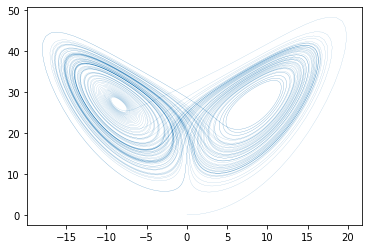

In [7]:
# test lorenz iterator:
time_steps = 10000

results = np.zeros((time_steps, 3))
results[0, :] = starting_point_L
for i in range(1, time_steps):
    x_last = results[i - 1, :]
    results[i, :] = f_L(x_last)

plt.plot(results[:, 0], results[:, 2], linewidth=0.1)

# Lorenz 96 Iterator:

### Plotting the pure Lorenz 96 system

In [13]:
# Lorenz 96 parameters:
dt_L96 = 0.01
dims_L96 = 60
np.random.seed(1)
starting_point_L96 = np.random.randn(dims_L96)

In [14]:
# Lorenz96 iterator:

_lorenz_96 = rescomp.simulations._lorenz_96
iterator = rescomp.simulations._runge_kutta
f_L96 = lambda x: iterator(_lorenz_96, dt_L96, x)

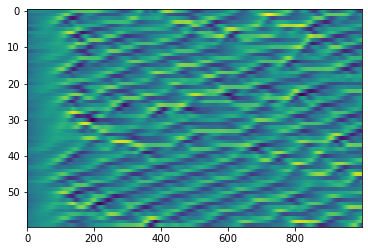

In [15]:
time_steps_L96 = 1000
results_L96 = np.zeros((time_steps_L96, dims_L96))

results_L96[0, :] = starting_point_L96
for i in range(1, time_steps_L96):
    x_last = results_L96[i - 1, :]
    results_L96[i, :] = f_L96(x_last)

plt.imshow(results_L96.T, aspect="auto")

# Reservoir:

In [180]:
import tensorflow as tf
from keras.layers import AveragePooling1D, Conv1D, InputLayer
from keras.models import Sequential
import networkx as nx

np.random.seed(2)

# Parameters:
time_steps = 10000
disc_timesteps = 100

# reservoir:
dims = [1000, 800, 500]
convs = [dims_L96, int(dims_L96 / 2), int(dims_L96/4)]
print(convs)

model1 = Sequential(
[
    InputLayer(input_shape=(dims_L96,1)),
    AveragePooling1D(pool_size=1, strides=1, padding='same')
])
def f1(x):
    return model1.predict(x.reshape(1, dims_L96, 1)).reshape(int(dims_L96))

model2 = Sequential(
[
    InputLayer(input_shape=(dims_L96,1)),
    AveragePooling1D(pool_size=2, strides=2, padding='same')
])
def f2(x):
    return model2.predict(x.reshape(1, dims_L96, 1)).reshape(int(dims_L96/2))

model3 = Sequential(
[
    InputLayer(input_shape=(dims_L96,1)),
    AveragePooling1D(pool_size=4, strides=4, padding='same')
])
def f3(x):
    return model3.predict(x.reshape(1, dims_L96, 1)).reshape(int(dims_L96/4))

pools = [f1, f2, f3]

w_in_scale = 0.5
w_ins = []
for i in range(3):
    w_in = np.random.uniform(low=-w_in_scale,
                             high=w_in_scale,
                             size=(dims[i], convs[i]))
    w_ins.append(w_in)

edge_prob = 0.01
Ws = []
for i in range(3):
    W = nx.to_numpy_array(nx.fast_gnp_random_graph(dims[i], edge_prob,seed=np.random))
    Ws.append(W)

res_states = []
for i in range(3):
    res_state = np.zeros((time_steps, dims[i]))
    res_state[0, :] = np.random.randn(dims[i])
    res_states.append(res_state)

[60, 30, 15]


In [181]:
starting_point_L96_use = starting_point_L96
starting_point_L_use = starting_point_L

# discard the starting timesteps:
for i in range(disc_timesteps):
    starting_point_L96_use = f_L96(starting_point_L96_use)
    starting_point_L_use = f_L(starting_point_L_use)

In [182]:
# L96
results_L96 = np.zeros((time_steps, dims_L96))
results_L96[0, :] = starting_point_L96_use

# L:
results_L = np.zeros((time_steps, 3))
results_L[0, :] = starting_point_L_use

##  Run RC:

In [183]:
# f = lambda x: np.tanh(x)
# f = lambda x: 0.1*x
# f = lambda x: np.heaviside(x,1)
f = lambda x: 1/(1+np.exp(-x))

for i in range(1, time_steps):
    x_last_in = results_L96[i - 1, :]

    x_last_res1 = res_states[0][i - 1, :]
    x_last_res2 = res_states[1][i - 1, :]
    x_last_res3 = res_states[2][i - 1, :]

    for k in range(3):
        x_last_res =  res_states[k][i - 1, :]

        # apply pooling:
        x_last_in_pool = pools[k](x_last_in)
        # print(x_last_in_pool.shape)
        # print(w_ins[k].shape)
        # coupl pooled input with reservoir
        inp =  w_ins[k].dot(x_last_in_pool) + Ws[k].dot(x_last_res)
        res_states[k][i, :] = f(inp)
    results_L96[i, :] = f_L96(x_last_in)

## Plot Reservoir quantities:

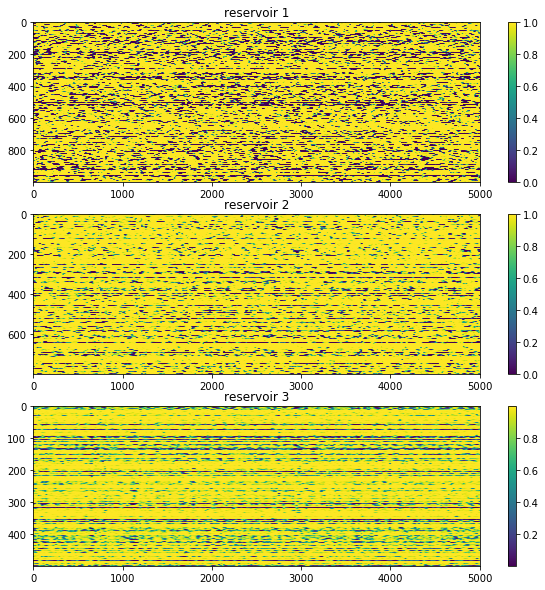

In [184]:
xlim = (0,5000)
# xlim = None

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

for k in range(3):
    ax = axs[k]
    im = ax.imshow(res_states[k][1:, :].T, aspect="auto")
    ax.set_xlim(xlim)
    ax.set_title(f"reservoir {k+1}")
    fig.colorbar(im, ax=ax, orientation='vertical')

(0, 0.1)

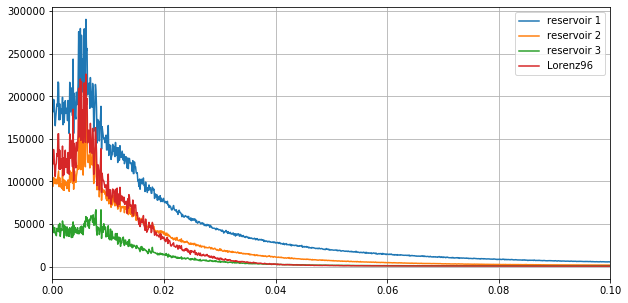

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for k in range(3):
    x, y = rescomp.measures.fourier_spectrum(res_states[k])
    ax.plot(x, y, label=f"reservoir {k+1}")


x, y = rescomp.measures.fourier_spectrum(results_L96)
ax.plot(x, y, label="Lorenz96")

ax.grid()
ax.legend()
ax.set_xlim(0, 0.1)

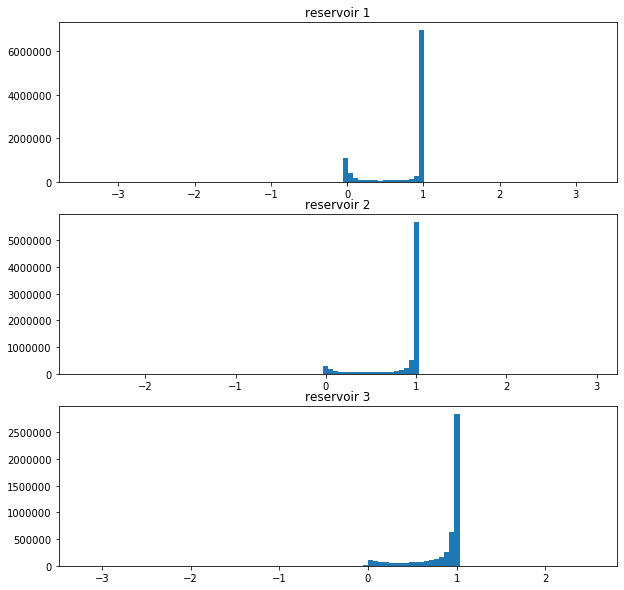

In [186]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for k in range(3):
    ax = axs[k]
    ax.hist(res_states[k].flatten(), bins=100)
    ax.set_title(f"reservoir {k+1}")

## Train and Test:

In [187]:
from sklearn.linear_model import Ridge, LogisticRegression
# Try to fit the coupled to the output:
sync_steps = 500
train_steps = 8000
test_steps = 1500


y_sync = results_L96[: sync_steps, :]

y_train = results_L96[sync_steps: sync_steps + train_steps, :]

y_test = results_L96[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]

y_test_pred_list = []

for k in range(3):
    x_sync = res_states[k][: sync_steps, :]
    x_train = res_states[k][sync_steps: sync_steps + train_steps, :]
    x_test = res_states[k][sync_steps + train_steps: sync_steps + train_steps + test_steps, :]
    # Train:
    model = Ridge(alpha=0.005)
    model.fit(x_train, y_train)

    y_test_pred = model.predict(x_test)
    y_test_pred_list.append(y_test_pred)

all_together = np.concatenate(res_states, axis=-1)
x_sync = all_together[: sync_steps, :]
x_train = all_together[sync_steps: sync_steps + train_steps, :]
x_test = all_together[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]
# Train:
model = Ridge(alpha=0.005)
model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
y_test_pred_list.append(y_test_pred)

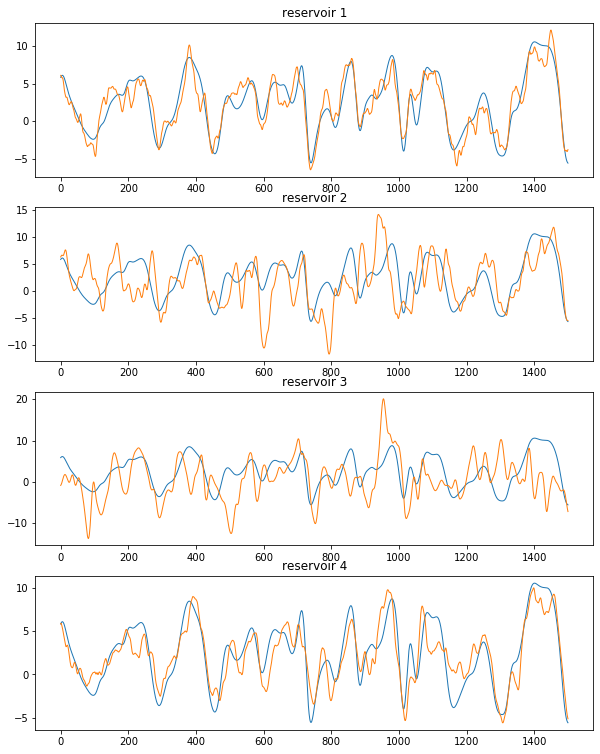

In [188]:
axis = 5

fig, axs = plt.subplots(4, 1, figsize=(10, 13))
for k in range(4):
    y_test_pred = y_test_pred_list[k]
    ax = axs[k]
    ax.plot(y_test[:, axis], linewidth=1)
    ax.plot(y_test_pred[:, axis], linewidth=1)
    ax.set_title(f"reservoir {k+1}")

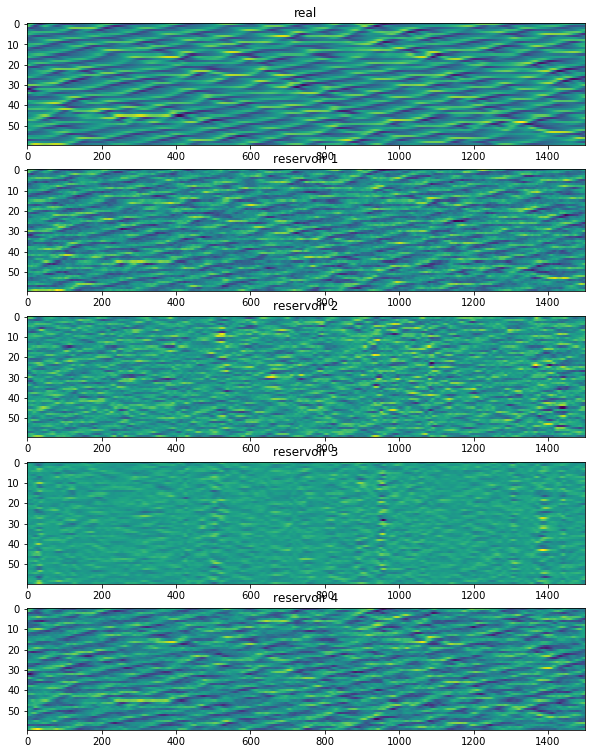

In [190]:
fig, axs = plt.subplots(5, 1, figsize=(10, 13))

axs[0].imshow(y_test.T, aspect="auto")
axs[0].set_title(f"real")

for k in range(0, 4):
    y_test_pred = y_test_pred_list[k]
    ax = axs[k+1]
    ax.imshow(y_test_pred.T, aspect="auto")
    ax.set_title(f"reservoir {k+1}")

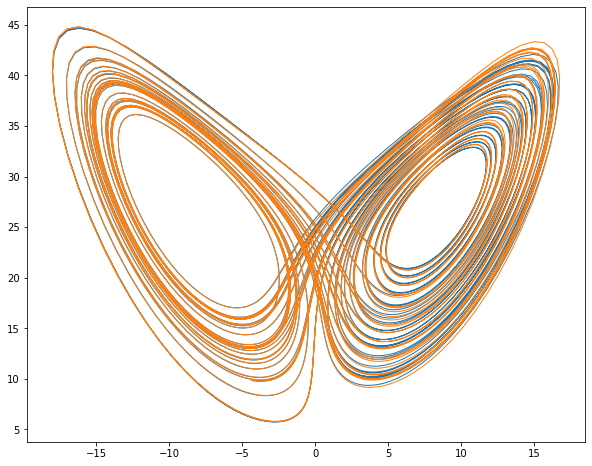

In [604]:
plt.figure(figsize=(10, 8))

plt.plot(y_test[:, 0], y_test[:, 2], linewidth=1)
plt.plot(y_test_pred[:, 0], y_test_pred[:, 2], linewidth=1)

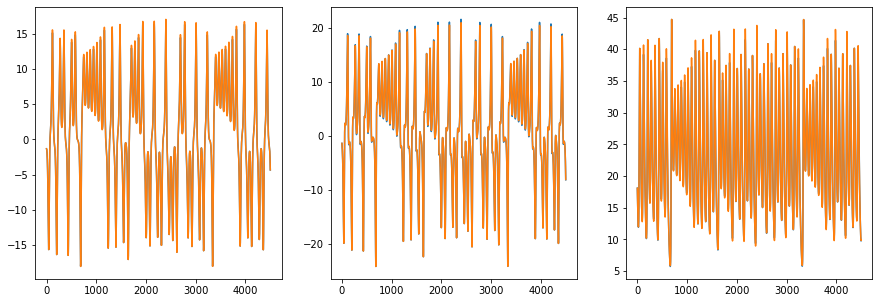

In [595]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axs[i]
    ax.plot(y_test[:, i])
    ax.plot(y_test_pred[:, i])

[0.71243533 0.19759869]
[499.71109667 263.17116446]


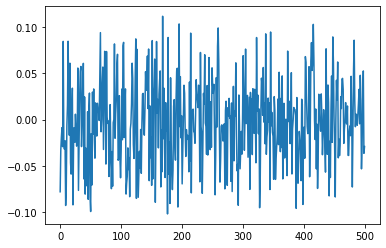

In [583]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(results_res)
# pca.fit(results_L96)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

pca1 = pca.components_[0]
plt.plot(pca1)

# KS iterator:


In [ ]:
dims = 200
L = 100

def data_creation_function_ks(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("kuramoto_sivashinsky_custom", dt, time_steps, starting_point, fft_type="scipy", dimensions=dims, system_size=L)

dt_ks = 0.5
def f_ks(x):
    return data_creation_function_ks(2, dt_ks, x)[-1]

In [ ]:
# test KS iterator:
time_steps = 1000
results_ks = np.zeros((time_steps, dims))

# default starting point
x = L * np.transpose(np.conj(np.arange(1, dims + 1))) / dims
starting_point = np.cos(2 * np.pi * x / L) * (1 + np.sin(2 * np.pi * x / L))

results_ks[0, :] = starting_point
for i in range(1, time_steps):
    x_last = results_ks[i - 1, :]
    results_ks[i, :] = f_ks(x_last)

plt.imshow(results_ks.T, aspect="auto")

## Coupling of both systems:


In [0]:
w_in_scale = 0.0001
w_in = np.random.uniform(low=-w_in_scale,
                         high=w_in_scale,
                         size=(dims, 3))

In [0]:
# test KS iterator:
time_steps = 2000

# ks
results_ks = np.zeros((time_steps, dims))
# default starting point
x = L * np.transpose(np.conj(np.arange(1, dims + 1))) / dims
starting_point = np.cos(2 * np.pi * x / L) * (1 + np.sin(2 * np.pi * x / L))
results_ks[0, :] = starting_point

# lorenz:
results = np.zeros((time_steps, 3))
results[0, :] = np.array([0, 1, 0])

for i in range(1, time_steps):
    x_last = results_ks[i - 1, :]
    x_last_in = results[i-1, :]
    x_add = w_in.dot(x_last_in)
    # if i > 1000:
    #     x_add = 0
    results_ks[i, :] = f_ks(x_last + x_add)
    results[i, :] = f(x_last_in)
plt.imshow(results_ks.T, aspect="auto")

In [ ]:
plt.plot(results[:, 0], results[:, 1], linewidth=0.1)
